## **Airport daily percentage of cancelled flights**


In this notebook we compute the percentage of cancelled flights per day, throughout the entire data set.

\begin{equation}
PercentageOfCancelledFlights(dayOfYear) = \frac{CancelledFlights(dayOfYear)}{NumberOfFlights(dayOfYear)} * 100
\end{equation}

#### Execution mode

If development mode is turned on, all the calculations will be performed on a reduced instance of the data set.

This allows to *save computation time* while developing.

In [1]:
# development mode
# False when performing real analytics
DEV = False

### threads to be used to run spark worker nodes locally
spark_local_threads = 4

# default transformed dataset path

transformed_dataset_path = '../dataset/01_cache_daily_cancelled_analytics.parquet'
missings_dataframe_path = '../dataset/01_cache_daily_cancelled_analytics_missings.pkl'

#### Find and import Apache Spark on current machine

In [2]:
import findspark
findspark.init()

In [3]:
# imports
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

from pathlib import Path

from missing_values_utils import *

#### Create a new session

In [4]:
# Build a Spark SQL Session for DataFrames
master = 'local[{}]'.format(spark_local_threads)
appName = 'Daily cancelled filghts'
spark = SparkSession  \
    .builder          \
    .appName(appName) \
    .master(master)   \
    .getOrCreate()

### Load data

If there exists a cached version of the already transformed dataset, just load it and skip all the unnecessary computation.

In [5]:
do_computation = True

if not DEV and Path(transformed_dataset_path).is_dir():
    df = spark.read.load(transformed_dataset_path)
    do_computation = False

Try to load the optimized parquet format data set. If parquet data set is not found, load full compressed data sets, reduce and save them.

In [6]:
from preprocessing_utils import *

if do_computation:
    if DEV:
        # DEV preprocessing
        perform_DEV_dataset_preprocessing(spark)
    else:
        # Production preprocessing
        perform_dataset_preprocessing(spark)

Starting preprocessing of ../dataset/*.csv.bz2
Preprocessing NOT performed.
Preprocessed dataset already exists: ../dataset/preprocessed_dataset.parquet



In [7]:
# Load the parquet dataset
if do_computation:
    if DEV:
        # Load DEV dataset
        df = load_DEV_preprocessed_dataset(spark)
    else:
        # Load production dataset
        df = load_preprocessed_dataset(spark)

Peprocessed dataset loaded.
../dataset/preprocessed_dataset.parquet


### Attributes selection

In [8]:
if do_computation:
    # Keep only the dimensions we need
    df = df.select(df['Year'], df['Month'], df['DayofMonth'], df['Cancelled'])
    # Explore the data
    df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- Cancelled: integer (nullable = true)



In [9]:
# get years from dataset
if do_computation:
    df_years = df.select('Year').distinct().toPandas()['Year']
else:
    df_years = list(df.columns)
    df_years.remove('DayOfMonth')
    df_years.remove('Month')

df_years = sorted(df_years)
print(df_years)

[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]


### Missing values exploration and exclusion

In [10]:
df.count()

91469371

In [11]:
df, df_missing = get_df_missing_and_drop_all_null(df, do_computation, missings_dataframe_path)

Years examined:
 [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008]

Missing values inspection:
0  null values in:  Year
0  null values in:  Month
0  null values in:  DayofMonth
0  null values in:  Cancelled


        Count  MissingsCount  MissingsPercentage
1994  5180048              0                 0.0
1995  5327435              0                 0.0
1996  5351983              0                 0.0
1997  5411843              0                 0.0
1998  5384721              0                 0.0
1999  5527884              0                 0.0
2000  5683047              0                 0.0
2001  5967780              0                 0.0
2002  5271359              0                 0.0
2003  6488540              0                 0.0
2004  7129270              0                 0.0
2005  7140596              0                 0.0
2006  7141922              0                 0.0
2007  7453215              0                 0.0
2008  7009728  

In [12]:
df.count()

91469371

### Compute daily-percentage analytics

In [13]:
if do_computation:
    df.describe('Cancelled').show()
    df.describe('Year').show()

+-------+--------------------+
|summary|           Cancelled|
+-------+--------------------+
|  count|            91469371|
|   mean|0.021325903727926587|
| stddev|  0.1444683695010413|
|    min|                   0|
|    max|                   1|
+-------+--------------------+

+-------+------------------+
|summary|              Year|
+-------+------------------+
|  count|          91469371|
|   mean|2001.5266289411786|
| stddev| 4.332419506702069|
|    min|              1994|
|    max|              2008|
+-------+------------------+



In [14]:
if do_computation:
    df = df.withColumn("Count", F.lit(1))

    df = df.groupBy(['Year', 'Month', 'DayOfMonth'])                \
           .sum('Count', 'Cancelled')                               \
           .withColumnRenamed('sum(Count)', 'Count')                \
           .withColumnRenamed('sum(Cancelled)', 'Cancelled')

    df.show(10)

+----+-----+----------+-----+---------+
|Year|Month|DayOfMonth|Count|Cancelled|
+----+-----+----------+-----+---------+
|2007|    1|        18|20815|      650|
|2007|    1|        19|20867|      511|
|2007|    9|        22|17136|      150|
|2006|    2|         3|19592|      413|
|2006|    8|        23|20386|      233|
|2004|    8|        14|18184|      863|
|2005|    1|        15|16826|      315|
|2005|   12|        25|16618|      177|
|2005|   12|         1|19246|      286|
|1995|    3|        20|15186|      232|
+----+-----+----------+-----+---------+
only showing top 10 rows



#### Leap years management

In [15]:
leap_years = range(1996,2009,4)
list(leap_years)

[1996, 2000, 2004, 2008]

In [16]:
# insert a zero flights count and a zero cancelled flights count for all the leap years
if do_computation:
    for i in range(1994, 2009):
        if i not in leap_years:
            new_row = spark.createDataFrame([[i, 2, 29, 0, 0]])
            df = df.union(new_row)

In [17]:
# Compute the percentage
if do_computation:
    df = df.withColumn('DailyCancelledFlightsPercentage', (df.Cancelled / df.Count) * 100)
    df = df.select('Year', 'Month', 'DayOfMonth', 'DailyCancelledFlightsPercentage')

In [18]:
if do_computation:
    df.show(20)

+----+-----+----------+-------------------------------+
|Year|Month|DayOfMonth|DailyCancelledFlightsPercentage|
+----+-----+----------+-------------------------------+
|2007|    1|        18|              3.122748018256065|
|2007|    1|        19|             2.4488426702448844|
|2007|    9|        22|             0.8753501400560224|
|2006|    2|         3|             2.1080032666394444|
|2006|    8|        23|             1.1429412341803198|
|2004|    8|        14|              4.745930488341399|
|2005|    1|        15|             1.8721026982051587|
|2005|   12|        25|             1.0651101215549403|
|2005|   12|         1|             1.4860230697287748|
|1995|    3|        20|              1.527722902673515|
|1995|    5|        24|              1.339165545087483|
|1994|   10|        28|            0.24920859432882064|
|1994|   12|        26|              1.077893024201749|
|2000|    1|         3|             2.8468627698522915|
|2000|    5|        15|             1.6666666666

#### Data format optimazion

In [19]:
# dataset transformation so to have:
# - for each year a column with the daily cancelled percentages 
# - have the dataset rows beign 366: days in a year
if do_computation:
    for y in df_years:
        df = df.withColumn(str(y) + '_val', df.Year == y)
        df = df.withColumn(str(y) + '_val', df[str(y) + '_val'].cast(IntegerType()))
        df = df.withColumn(str(y), df[str(y) + '_val'] * df.DailyCancelledFlightsPercentage)
        df = df.drop(str(y) + '_val')

    df = df.drop('DailyCancelledFlightsPercentage')

    # do the sum so that the columns will shrink all to the same size of 366 rows
    df = df.groupBy('Month', 'DayOfMonth')                     \
           .sum()                                              \
           .drop('sum(Year)', 'sum(Month)', 'sum(DayOfMonth)') \
           .orderBy('Month', 'DayOfMonth')

    # rename colums as year name
    for y in df_years:
        df = df.withColumnRenamed('sum({})'.format(y), str(y))
    

In [20]:
if do_computation:
    df.write.mode('overwrite').save(transformed_dataset_path, format='parquet')

In [21]:
df.printSchema()

root
 |-- Month: long (nullable = true)
 |-- DayOfMonth: long (nullable = true)
 |-- 1994: double (nullable = true)
 |-- 1995: double (nullable = true)
 |-- 1996: double (nullable = true)
 |-- 1997: double (nullable = true)
 |-- 1998: double (nullable = true)
 |-- 1999: double (nullable = true)
 |-- 2000: double (nullable = true)
 |-- 2001: double (nullable = true)
 |-- 2002: double (nullable = true)
 |-- 2003: double (nullable = true)
 |-- 2004: double (nullable = true)
 |-- 2005: double (nullable = true)
 |-- 2006: double (nullable = true)
 |-- 2007: double (nullable = true)
 |-- 2008: double (nullable = true)



In [22]:
df.select('1994', '1996', '2001', '2007').show(10)

+------------------+------------------+------------------+------------------+
|              1994|              1996|              2001|              2007|
+------------------+------------------+------------------+------------------+
|0.5264023688106596|3.0900723208415517| 7.400037311112493|1.8350968665337628|
|0.4492230650268797|  6.72579453067258| 4.008630479218715|0.9954238807378403|
| 1.541819205857505|7.1923102776097325|3.2720650998691174| 0.839897504033406|
|15.560882746950574|2.8392652896454282|2.6977803073420605|  2.37118320610687|
| 4.765613935703159|2.9633113828786453| 4.989758761948111|2.7675716944219118|
| 5.416755640970887|  5.07185122569738|3.2939955907145637| 1.141539672721138|
| 8.754974417282547| 25.97874919774656| 2.738993523854792| 1.124558749369642|
| 9.567631892106307|29.014598540145986|2.8929163569835916|1.7102229054573406|
|1.1112791049289386|16.927559802127803| 3.116957392050329|1.0085954190887862|
|1.8481801444554598| 5.157224179994579| 4.055368071841217|0.7662

In [23]:
pdf = df.toPandas()

In [24]:
# rows?
assert(366 == pdf.shape[0])
pdf.shape

(366, 17)

In [25]:
# update index to match the day of the year!
pdf.index = pdf.index + 1

In [26]:
#pdf.head(65)
pdf.head()

,Month,DayOfMonth,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
1,1,1,0.526402,1.058201,3.090072,2.313218,0.841365,2.745820,5.616711,7.400037,0.824279,0.817641,1.156372,1.225079,1.565285,1.835097,2.887372
2,1,2,0.449223,1.085271,6.725795,4.256721,1.040861,22.986174,1.992935,4.008630,4.502776,1.343912,3.201092,0.931881,4.043623,0.995424,2.438675
3,1,3,1.541819,1.775262,7.192310,2.808102,1.617592,15.144628,2.846863,3.272065,6.581214,2.024377,1.500753,1.617964,3.611637,0.839898,2.268711
4,1,4,15.560883,2.272874,2.839265,1.771453,1.676289,6.294622,3.369008,2.697780,2.311980,1.314240,6.338884,2.966507,1.429391,2.371183,3.674327
5,1,5,4.765614,2.155619,2.963311,3.017984,3.157408,4.057876,2.185376,4.989759,0.379687,1.349053,3.019592,7.438643,0.901448,2.767572,2.523659


In [27]:
pdf.tail()

,Month,DayOfMonth,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
362,12,27,0.890943,1.028069,4.551761,0.508069,3.134514,1.167192,3.008695,1.319929,0.738084,0.838833,3.959081,1.084935,1.199437,2.305393,4.748991
363,12,28,0.564023,1.143824,3.058104,0.635164,3.417621,2.440258,2.413772,1.395477,0.307170,0.658997,2.752881,0.952381,2.024370,4.510253,1.570976
364,12,29,0.361882,1.192008,3.448754,2.978921,3.567425,1.436436,3.298360,0.319788,0.323078,0.980549,1.453488,1.026196,6.553163,0.940749,0.744337
365,12,30,0.564127,0.484541,4.328033,2.598183,2.187953,1.449644,16.860670,0.570613,2.808713,0.707927,1.843114,1.124755,3.250604,1.522896,1.537383
366,12,31,0.992063,1.730665,2.537848,1.085432,1.165880,2.786458,9.149301,0.576302,0.942484,0.565900,0.993871,1.337856,2.125939,2.970016,3.517907


##### Data visualization functions

Scroll down to see the charts

In [28]:
# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from ipywidgets import interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import numpy as np

import calendar

In [29]:
fig_size=[15,10]
title_size=20

In [30]:
def get_years_df(years):
    """
    Return the dataframe of the selected years 
    """
    years = [str(y) for y in range(*years)]
    return pdf[years]


def plot_cancelled_time_series(years):
    # select requested years from dataframe 
    df = get_years_df(years)
    
    # xticks are the last day of the month counted as day of the year
    xticks = [0]
    for m in range(1,13):
        new_val = xticks[-1] + calendar.monthrange(2016, m)[1]
        xticks.append(new_val)

    # xlabels are the months abbreviations
    xlabels = list(calendar.month_abbr)[1:]

    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['axes.titlesize'] = title_size
    fig, ax = plt.subplots()
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels) 
    
    ax.set_xlabel('Months', size=16)
    ax.set_ylabel('Cancellation percentage', size=16)
    ax.set_title('Daily cancelled flights percentage', pad=20)

    plt.xlim(xmin=-4, xmax=370)
    df.plot(grid=True, rot=45, ax=ax)
    plt.legend(loc='best')
    

def plot_average_cancelled_flights(years):
    # select requested years from dataframe 
    df = get_years_df(years)    
    averages = []
    for y in range(*years):
        averages.append(df[str(y)].mean())

    labels = [str(y) for y in range(*years)]
    
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['axes.titlesize'] = title_size
    fig, ax = plt.subplots()
    indexes = np.arange(len(averages))
    
    rects = ax.bar(indexes, averages, label=labels, color='orangered')

    # add percentages on bars
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height - 0.18,
                str(np.round(height, decimals=2)) + '%',
                ha='center', va='bottom', color='w', size=13)
        
    ax.set_xlabel('Years', size=16)
    ax.set_ylabel('Cancellation percentage', size=16)
    ax.set_title('Average of cancelled flights percentages', pad=20)
    
    ax.set_xticks(indexes)
    ax.set_xticklabels(labels)
    ax.xaxis.set_tick_params(labelsize=14)
    ax.legend(loc='best', labels=['Cancellation percentage'])
    plt.show()

In [31]:
def ui_callback(years):
    years = (int(years[0]), int(years[1]) + 1)  #due to range() function
    
    plot_cancelled_time_series(years)

    plot_average_cancelled_flights(years)


# Years selection range
years_w = widgets.SelectionRangeSlider(options=[(str(y), y) for y in df_years],
                                       index=(0, 2),
                                       description='Years',
                                       continuous_update=False)
ui = widgets.HBox([years_w])

## Data Visualization

Analytics showhing the percentage of daily cancelled flights are reported below.

### Missing values and valid data

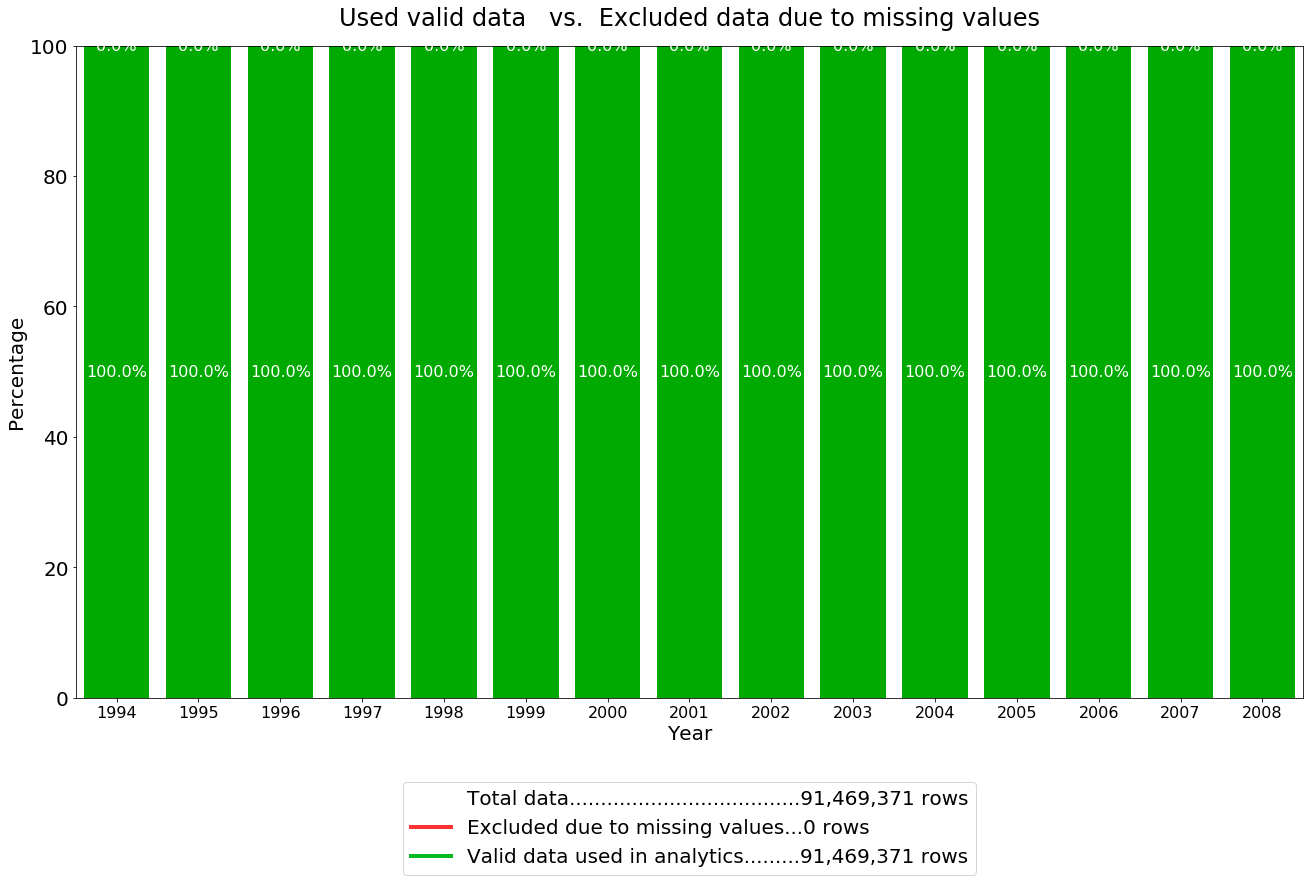

In [32]:
plot_missing_values_stacked_bar(df_missing)

### Percentage of daily cancelled flights

A line plot was used to display percentages as a time series. 

- _x axis_ is the day number, from day 1 (1st of January of the selected year) to 366 (30th of December of the selected year)
- _y axis_ reports the daily percentage of cancelled flights

Moreover, also bar plot is generated to display the yearly average of cancelled flights.


#### Data discoveries

- The analytics is performed over the totality of the data. There're no missing values for the analized attributes.

In [33]:
out = widgets.interactive_output(ui_callback, {'years': years_w})
display(ui, out)

Output()